# Importing Libraries

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, classification_report
import sys
from ast import literal_eval
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel
import os
import time
import math
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

*We are using the Twitter Emotion Classification dataset available in Kaggle. In this dataset we have 6 different sentiments, classification labels include sadness (0), joy (1), love (2), anger (3), fear (4) and surprise (5).*

In [24]:
train_path = "training.csv"
val_path = "validation.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')

train_data.head(10)

Training data: (16000, 2)
Validation data: (2000, 2)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [25]:
assert 'text' in train_data.columns and 'label' in train_data.columns, "Training data must have 'text' and 'label' columns."
assert 'text' in val_data.columns and 'label' in val_data.columns, "Validation data must have 'text' and 'label' columns."

print("Class distribution in training data:")
print(train_data['label'].value_counts())

Class distribution in training data:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


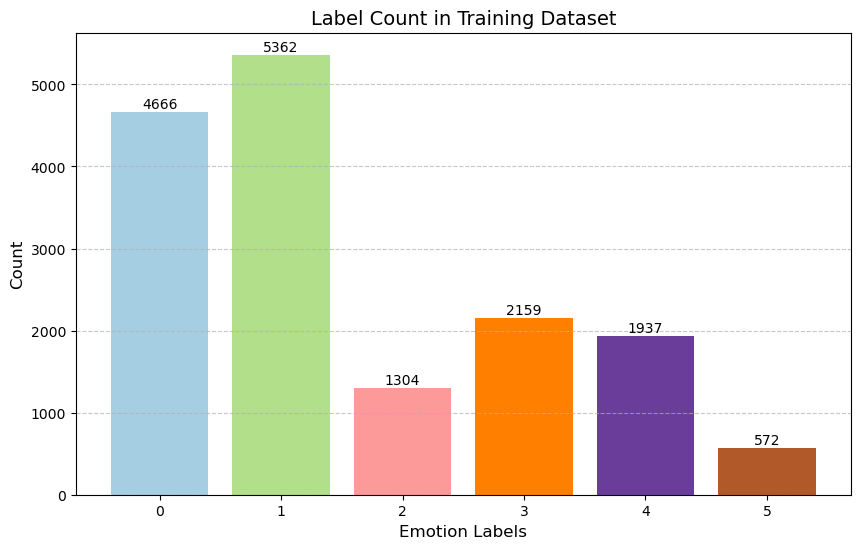

In [26]:
label_counts = train_data['label'].value_counts()
label_counts = label_counts.sort_index()

plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(label_counts)))
bars = plt.bar(label_counts.index, label_counts.values, color=colors)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.title("Label Count in Training Dataset", fontsize=14)
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=label_counts.index, labels=label_counts.index, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

*As we can see, labels 0 and 1 are very high in number as compared to label 5 which is very less. So, we balance the dataset.*

In [27]:
def balance_classes(data):

    class_counts = data['label'].value_counts()
    max_count = class_counts.max()

    balanced_data = pd.DataFrame()
    for label in class_counts.index:
        class_subset = data[data['label'] == label]
        balanced_subset = resample(
            class_subset,
            replace=True,
            n_samples=max_count,  
            random_state=42
        )
        balanced_data = pd.concat([balanced_data, balanced_subset])
    
    return balanced_data.sample(frac=1, random_state=42) 
train_data = balance_classes(train_data)

print("Class distribution in training data:")
print(train_data['label'].value_counts())

Class distribution in training data:
label
3    5362
1    5362
5    5362
4    5362
0    5362
2    5362
Name: count, dtype: int64


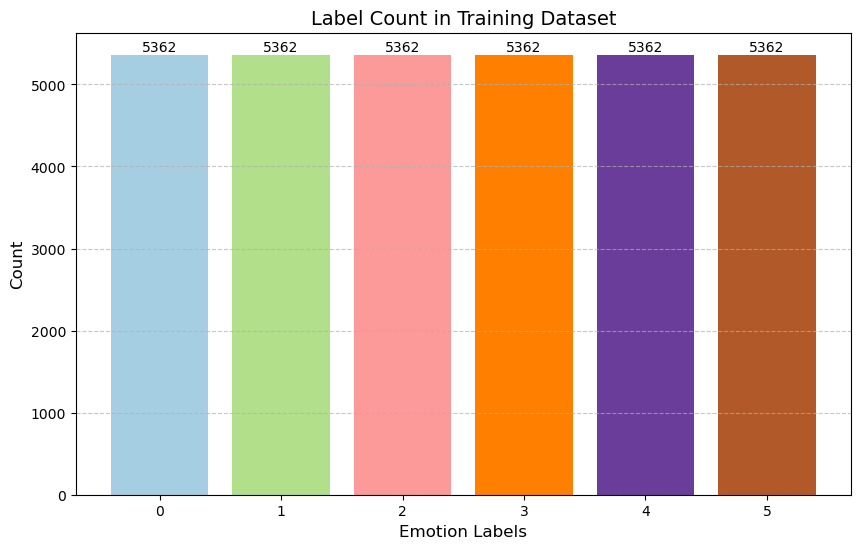

In [28]:
label_counts = train_data['label'].value_counts()
label_counts = label_counts.sort_index()

plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(label_counts)))  # Generate a color palette
bars = plt.bar(label_counts.index, label_counts.values, color=colors)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.title("Label Count in Training Dataset", fontsize=14)
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=label_counts.index, labels=label_counts.index, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Tokenization

In [29]:
# Initialization using GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

def process_and_tokenize(dataset):

    tokenized_texts = []
    labels = []
    
    for _, row in dataset.iterrows():
        text = row['text']
        label = row['label']
        
        tokens = enc.encode_ordinary(text)[:128] 
        tokenized_texts.append(tokens)
        labels.append(label)
    
    return tokenized_texts, labels

train_texts, train_labels = process_and_tokenize(train_data)
val_texts, val_labels = process_and_tokenize(val_data)

def pad_sequences(sequences, block_size=128, pad_token=0):

    return [seq + [pad_token] * (block_size - len(seq)) if len(seq) < block_size else seq for seq in sequences]

train_texts = pad_sequences(train_texts)
val_texts = pad_sequences(val_texts)

train_data = {
    "tokens": np.array(train_texts, dtype=np.uint16),
    "labels": np.array(train_labels, dtype=np.uint8),
}

val_data = {
    "tokens": np.array(val_texts, dtype=np.uint16),
    "labels": np.array(val_labels, dtype=np.uint8),
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

np.savez_compressed(os.path.join(output_dir, "train.npz"), **train_data)
np.savez_compressed(os.path.join(output_dir, "val.npz"), **val_data)

print(f"Preparation complete. Data saved to {output_dir}")
print(f"npz files created")

Preparation complete. Data saved to data
npz files created


## Configuration

In [30]:
global_defaults = {
    "batch_size": 32,
    "learning_rate": 1e-4,
    "max_iters": 2000,
    "eval_interval": 200,
    "log_interval": 10,
    "block_size": 128,
    "device": "mps",  
    "dataset": "data",  
    "init_from": "scratch", 
    "decay_lr": True,
}

globals().update(global_defaults)

def parse_config_arguments(args):

    for arg in args:
        if arg.startswith("-"):
            continue
        if '=' not in arg:
            assert not arg.startswith('--'), f"Invalid argument format: {arg}"
            config_file = arg
            print(f"Overriding config with {config_file}:")
            with open(config_file) as f:
                print(f.read())
            exec(open(config_file).read())
        else:
            assert arg.startswith('--'), f"Invalid argument format: {arg}"
            key, val = arg.split('=')
            key = key[2:]
            if key in globals():
                try:
                    attempt = literal_eval(val)
                except (SyntaxError, ValueError):
                    attempt = val
                if not isinstance(attempt, type(globals()[key])):
                    raise TypeError(f"Type mismatch for {key}: expected {type(globals()[key])}, got {type(attempt)}")
                print(f"Overriding: {key} = {attempt}")
                globals()[key] = attempt
            else:
                raise ValueError(f"Unknown config key: {key}")

if __name__ == "__main__":
    parse_config_arguments(sys.argv[1:])

Overriding config with /Users/roshankandel/Library/Jupyter/runtime/kernel-be35433d-44bb-4983-835a-3f4a70a67967.json:
{
  "shell_port": 51488,
  "iopub_port": 51489,
  "stdin_port": 51490,
  "control_port": 51492,
  "hb_port": 51491,
  "ip": "127.0.0.1",
  "key": "16a8197f-b297a748bdbda6f6b66658a5",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/roshankandel/N copy/Emotion Classifier (Comments)-Copy1.ipynb"
}


# GPT Model

*This model is based on Karpathy's NanoGPT model. We modified the model such that it takes both text and labels. The LayerNorm, CausalSelfAttention and MLP are not changed. GPT is modified to include an emotion classification head to predict the emotion class. The forward function computes logits for emotion labels instead of next-token logits.*

Full definition of a GPT Language Model with a classification head for emotion prediction

In [31]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(config.block_size, config.block_size))
                .view(1, 1, config.block_size, config.block_size)
            )

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v, attn_mask=None,
                dropout_p=self.dropout if self.training else 0, is_causal=True
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.1
    bias: bool = True
    num_classes: int = 6  # Added for classification

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.classification_head = nn.Linear(config.n_embd, config.num_classes)  # Classification head for emotion prediction

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, class_weights=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        logits = self.classification_head(x[:, -1, :])  # Use the last token's representation for classification

        loss = None
        if targets is not None:
            if class_weights is not None:
                class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
            loss = F.cross_entropy(logits, targets, weight=class_weights)

        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        config_args = {
            'gpt2': dict(n_layer=12, n_head=12, n_embd=768),
        }[model_type]
        config_args.update(override_args or {})
        config = GPTConfig(**config_args)
        model = cls(config)
        hf_model = GPT2LMHeadModel.from_pretrained(model_type)
        model.load_state_dict(hf_model.state_dict(), strict=False)
        return model

# Training

In [5]:
out_dir = 'out'
eval_interval = 100  
log_interval = 10    
eval_only = False    
init_from = 'scratch'
dataset = 'data'  
batch_size = 16
block_size = 128  
learning_rate = 1e-4
max_iters = 10000
grad_clip = 1.0  
decay_lr = True  
num_classes = 6  
device = 'mps'  
dtype = 'float32'
class_weights = [1.0, 1.0, 2.5, 2.0, 2.0, 3.0]
# -----------------------------------------------------------------------------

train_data = np.load(os.path.join(dataset, "train.npz"))
val_data = np.load(os.path.join(dataset, "val.npz"))

def get_batch(split):

    data = train_data if split == 'train' else val_data
    tokens = data['tokens']
    labels = data['labels']

    ix = np.random.randint(0, len(labels), batch_size)

    x = tokens[ix] 
    y = labels[ix] 

    x = torch.tensor(x, dtype=torch.long, device=device)
    y = torch.tensor(y, dtype=torch.long, device=device)

    return x, y

config = GPTConfig(
    block_size=block_size,
    vocab_size=50304,  # GPT-2 vocab size
    n_layer=12,
    n_head=12,
    n_embd=768,
    num_classes=num_classes
)
if init_from == 'scratch':
    print("Initializing a new model from scratch")
    model = GPT(config)
elif init_from == 'resume':
    print(f"Resuming training from {out_dir}")
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = GPT(config)
    model.load_state_dict(checkpoint['model'])
elif init_from == 'gpt2':
    print("Initializing model from GPT-2 pretrained weights")
    model = GPT.from_pretrained("gpt2", override_args={"num_classes": num_classes})

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def get_lr(iter_num):
    if not decay_lr:
        return learning_rate
    if iter_num < 1000:
        return learning_rate * (iter_num / 1000)
    decay_iter = min(iter_num - 1000, max_iters - 1000)
    return 0.5 * learning_rate * (1 + math.cos(math.pi * decay_iter / (max_iters - 1000)))


iter_num = 0
best_val_loss = float('inf')
os.makedirs(out_dir, exist_ok=True)

while iter_num < max_iters:
    x, y = get_batch('train')

    logits, loss = model(x, y, class_weights=class_weights)

    optimizer.zero_grad()
    loss.backward()

    if grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    optimizer.step()

    if iter_num % log_interval == 0:
        print(f"Iter {iter_num}, Loss: {loss.item():.4f}")

    if iter_num % eval_interval == 0:
        model.eval()
        val_losses = []
        val_true = []
        val_pred = []

        for _ in range(10):  
            x_val, y_val = get_batch('val')
            with torch.no_grad():
                logits, val_loss = model(x_val, y_val)
            val_losses.append(val_loss.item())

            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            val_pred.extend(preds)
            val_true.extend(y_val.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        val_accuracy = accuracy_score(val_true, val_pred)
        val_f1 = f1_score(val_true, val_pred, average="weighted")

        print(f"Iter {iter_num}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        model.train()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint = {
                'model': model.state_dict(),
                'config': config,
                'iter_num': iter_num,
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
            print(f"Saved checkpoint to {out_dir}")

    iter_num += 1

print("Training completed.")


Initializing a new model from scratch
Iter 0, Loss: 1.9765
Iter 0, Validation Loss: 4.9238, Accuracy: 0.0813, F1 Score: 0.0123
Saved checkpoint to out
Iter 10, Loss: 1.7490
Iter 20, Loss: 1.7771
Iter 30, Loss: 1.9524
Iter 40, Loss: 1.9829
Iter 50, Loss: 1.8282
Iter 60, Loss: 1.8260
Iter 70, Loss: 1.8267
Iter 80, Loss: 1.8165
Iter 90, Loss: 1.8592
Iter 100, Loss: 1.6292
Iter 100, Validation Loss: 2.3510, Accuracy: 0.0375, F1 Score: 0.0027
Saved checkpoint to out
Iter 110, Loss: 2.1384
Iter 120, Loss: 1.9204
Iter 130, Loss: 1.8415
Iter 140, Loss: 1.8373
Iter 150, Loss: 1.7770
Iter 160, Loss: 1.7219
Iter 170, Loss: 1.7696
Iter 180, Loss: 1.4973
Iter 190, Loss: 1.1522
Iter 200, Loss: 1.5324
Iter 200, Validation Loss: 1.7463, Accuracy: 0.1500, F1 Score: 0.0791
Saved checkpoint to out
Iter 210, Loss: 1.7322
Iter 220, Loss: 1.6369
Iter 230, Loss: 1.9911
Iter 240, Loss: 1.4640
Iter 250, Loss: 0.9273
Iter 260, Loss: 1.2245
Iter 270, Loss: 1.3455
Iter 280, Loss: 1.5254
Iter 290, Loss: 1.3224
Ite

In [6]:
final_checkpoint_path = os.path.join(out_dir, 'final_model.pt')
torch.save(checkpoint, final_checkpoint_path)
print(f"Final model saved to {final_checkpoint_path}")

Final model saved to out/final_model.pt


*It took approx 5 hours for the model to train for 10000 iterations on an mps device.*

# Evaluation

In [32]:
# Configuration
test_file = "test.csv"  
out_dir = "out"         
device = "mps"        
dtype = "float32"       
batch_size = 16         
block_size = 128        
# -----------------------------------------------------------------------------

# Load the test dataset
test_data = pd.read_csv(test_file)
assert 'text' in test_data.columns and 'label' in test_data.columns, "Test file must have 'text' and 'label' columns."

enc = tiktoken.get_encoding("gpt2")

def preprocess_texts(data):
    inputs = []
    labels = []
    for _, row in data.iterrows():
        text = row['text']
        label = row['label']
        tokens = enc.encode_ordinary(text)[:block_size]  # Truncate to block size
        inputs.append(tokens)
        labels.append(label)
    return inputs, labels

def pad_sequences(sequences, block_size=128, pad_token=0):

    return [seq + [pad_token] * (block_size - len(seq)) if len(seq) < block_size else seq for seq in sequences]

test_inputs, test_labels = preprocess_texts(test_data)
test_inputs = pad_sequences(test_inputs, block_size=block_size)

test_inputs = torch.tensor(test_inputs, dtype=torch.long, device=device)
test_labels = torch.tensor(test_labels, dtype=torch.long, device=device)

ckpt_path = os.path.join(out_dir, "ckpt.pt")
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = checkpoint['config']
model = GPT(gptconf)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

preds = []
with torch.no_grad():
    for i in range(0, len(test_inputs), batch_size):
        batch_inputs = test_inputs[i:i+batch_size]
        logits, _ = model(batch_inputs)
        batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
        preds.extend(batch_preds)

true_labels = test_labels.cpu().numpy()
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=[
    "sadness", "joy", "love", "anger", "fear", "surprise"
]))

test_data['predicted'] = preds
test_data.to_csv("test_results.csv", index=False)
print("Test results saved to test_results.csv")

Classification Report:
              precision    recall  f1-score   support

     sadness       0.91      0.89      0.90       581
         joy       0.94      0.85      0.89       695
        love       0.66      0.91      0.76       159
       anger       0.89      0.87      0.88       275
        fear       0.85      0.84      0.85       224
    surprise       0.57      0.82      0.67        66

    accuracy                           0.87      2000
   macro avg       0.80      0.86      0.83      2000
weighted avg       0.88      0.87      0.87      2000

Test results saved to test_results.csv


In [33]:
t1= "test_results.csv"
t2 = pd.read_csv(t1)

In [9]:
t2.head(30)

,text,label,predicted
0,im feeling rather rotten so im not very ambiti...,0,0
1,im updating my blog because i feel shitty,0,0
2,i never make her separate from me because i do...,0,0
3,i left with my bouquet of red and yellow tulip...,1,1
4,i was feeling a little vain when i did this one,0,0
5,i cant walk into a shop anywhere where i do no...,4,4
6,i felt anger when at the end of a telephone call,3,0
7,i explain why i clung to a relationship with a...,1,1
8,i like to have the same breathless feeling as ...,1,1
9,i jest i feel grumpy tired and pre menstrual w...,3,3


#### Short sentences Vs Long sentences

The short and long sentences dataset was created by limiting the threshold on the test dataset.

In [15]:
tokenizer = enc
max_token_threshold = 50

test_data['tokenized_length'] = test_data['text'].apply(lambda x: len(tokenizer.encode(x)))

# Separate long and short sentences
short_sentences = test_data[test_data['tokenized_length'] <= max_token_threshold]
long_sentences = test_data[test_data['tokenized_length'] > max_token_threshold]

print("Short Sentences:")
print(short_sentences[['text', 'tokenized_length']].head())

print("\nLong Sentences:")
print(long_sentences[['text', 'tokenized_length']].head())

Short Sentences:
                                                text  tokenized_length
0  im feeling rather rotten so im not very ambiti...                11
1          im updating my blog because i feel shitty                 8
2  i never make her separate from me because i do...                22
3  i left with my bouquet of red and yellow tulip...                23
4    i was feeling a little vain when i did this one                11

Long Sentences:
                                                  text  tokenized_length
119  i feel like i know who most of them are by now...                61
138  i have an ed i will tell you that i know i sho...                57
303  i was so impressed with the show especially fo...                51
403  i feel like there is no way out being humiliat...                54
439  i always feel a bit awkward when i comment on ...                54


In [34]:
def preprocess_and_split_by_length(data, threshold=50):
    short_inputs, short_labels = [], []
    long_inputs, long_labels = [], []

    for _, row in data.iterrows():
        text = row['text']
        label = row['label']
        tokens = enc.encode_ordinary(text)
        if len(tokens) <= threshold:
            short_inputs.append(tokens)
            short_labels.append(label)
        else:
            long_inputs.append(tokens)
            long_labels.append(label)

    return (short_inputs, short_labels), (long_inputs, long_labels)

def pad_sequences(sequences, block_size=128, pad_token=0):

    return [seq + [pad_token] * (block_size - len(seq)) if len(seq) < block_size else seq[:block_size] for seq in sequences]

threshold = 50 
(short_inputs, short_labels), (long_inputs, long_labels) = preprocess_and_split_by_length(test_data, threshold)
short_inputs = pad_sequences(short_inputs, block_size)
long_inputs = pad_sequences(long_inputs, block_size)

short_inputs = torch.tensor(short_inputs, dtype=torch.long, device=device)
short_labels = torch.tensor(short_labels, dtype=torch.long, device=device)
long_inputs = torch.tensor(long_inputs, dtype=torch.long, device=device)
long_labels = torch.tensor(long_labels, dtype=torch.long, device=device)

def evaluate_model(inputs, labels, batch_size=32):
    preds = []
    with torch.no_grad():
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size]
            logits, _ = model(batch_inputs)
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
            preds.extend(batch_preds)

    true_labels = labels.cpu().numpy()
    report = classification_report(true_labels, preds, target_names=[
        "sadness", "joy", "love", "anger", "fear", "surprise"
    ])
    return report

print("Evaluating on short sentences...")
short_report = evaluate_model(short_inputs, short_labels)
print("Short Sentence Performance:\n", short_report)

print("\nEvaluating on long sentences...")
long_report = evaluate_model(long_inputs, long_labels)
print("Long Sentence Performance:\n", long_report)

Evaluating on short sentences...
Short Sentence Performance:
               precision    recall  f1-score   support

     sadness       0.91      0.89      0.90       569
         joy       0.94      0.85      0.89       682
        love       0.67      0.91      0.77       158
       anger       0.88      0.88      0.88       272
        fear       0.85      0.84      0.85       221
    surprise       0.57      0.81      0.67        63

    accuracy                           0.87      1965
   macro avg       0.80      0.86      0.83      1965
weighted avg       0.88      0.87      0.87      1965


Evaluating on long sentences...
Long Sentence Performance:
               precision    recall  f1-score   support

     sadness       0.91      0.83      0.87        12
         joy       0.92      0.92      0.92        13
        love       0.00      0.00      0.00         1
       anger       1.00      0.67      0.80         3
        fear       1.00      0.67      0.80         3
    surpr

#### Synthetic Diary Dataset

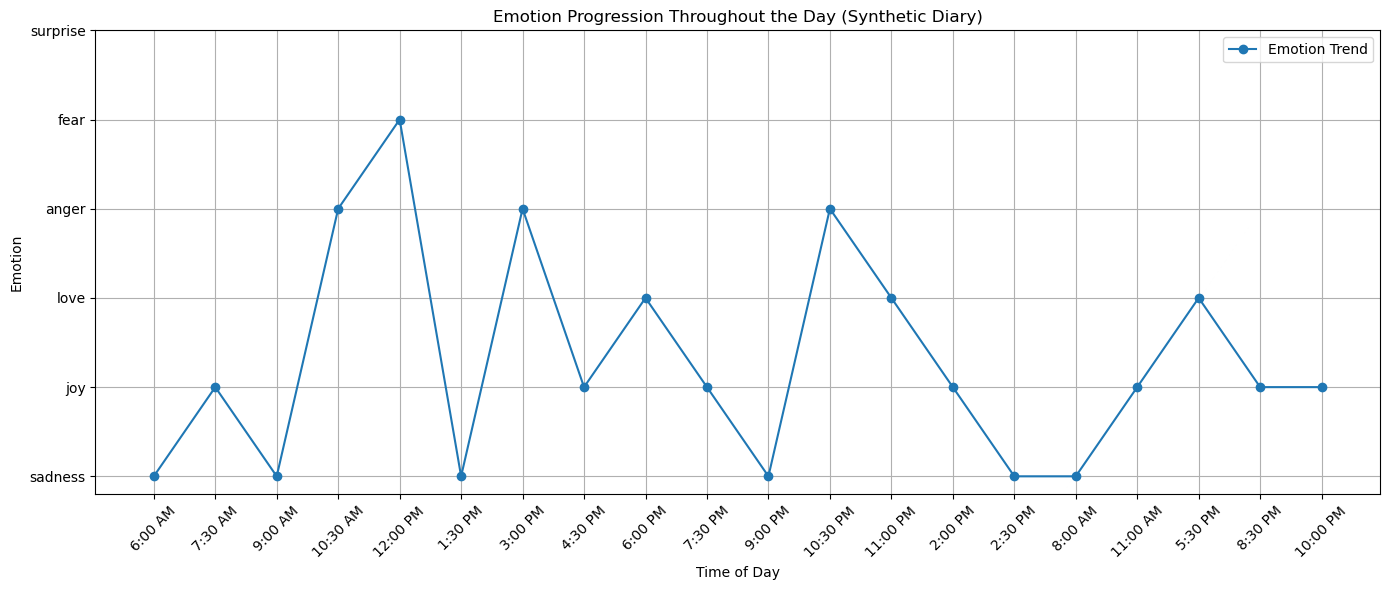

[6:00 AM] Woke up feeling refreshed and ready to conquer the day. -> Predicted Emotion: sadness
[7:30 AM] Enjoyed a peaceful morning walk, feeling calm and relaxed. -> Predicted Emotion: joy
[9:00 AM] Had a successful meeting that boosted my confidence. -> Predicted Emotion: sadness
[10:30 AM] Worked hard on a challenging task, feeling accomplished. -> Predicted Emotion: anger
[12:00 PM] Shared a hearty laugh with colleagues over lunch. -> Predicted Emotion: fear
[1:30 PM] Faced a frustrating technical issue, but managed to fix it. -> Predicted Emotion: sadness
[3:00 PM] Took a short break to read an inspiring article. -> Predicted Emotion: anger
[4:30 PM] Discussed weekend plans with friends, feeling excited. -> Predicted Emotion: joy
[6:00 PM] Watched an old favorite movie, feeling nostalgic. -> Predicted Emotion: love
[7:30 PM] Played an engaging game with family, feeling joyful. -> Predicted Emotion: joy
[9:00 PM] Revisited some past memories, feeling sentimental. -> Predicted Emot

In [37]:
# Manually create synthetic diary entries
diary_entries = {
    "Time": [
        "6:00 AM", "7:30 AM", "9:00 AM", "10:30 AM", "12:00 PM",
        "1:30 PM", "3:00 PM", "4:30 PM", "6:00 PM", "7:30 PM",
        "9:00 PM", "10:30 PM", "11:00 PM", "2:00 PM", "2:30 PM",
        "8:00 AM", "11:00 AM", "5:30 PM", "8:30 PM", "10:00 PM"
    ],
    "Entry": [
        "Woke up feeling refreshed and ready to conquer the day.",
        "Enjoyed a peaceful morning walk, feeling calm and relaxed.",
        "Had a successful meeting that boosted my confidence.",
        "Worked hard on a challenging task, feeling accomplished.",
        "Shared a hearty laugh with colleagues over lunch.",
        "Faced a frustrating technical issue, but managed to fix it.",
        "Took a short break to read an inspiring article.",
        "Discussed weekend plans with friends, feeling excited.",
        "Watched an old favorite movie, feeling nostalgic.",
        "Played an engaging game with family, feeling joyful.",
        "Revisited some past memories, feeling sentimental.",
        "Had a deep conversation with a close friend.",
        "Felt a mix of joy and longing reflecting on the day.",
        "Prepared a special dinner, feeling proud of my cooking skills.",
        "Listened to calming music, unwinding before bed.",
        "Started the day with energizing yoga.",
        "Received praise for a project, feeling valued.",
        "Helped a neighbor with a task, feeling kind and compassionate.",
        "Read a motivational book before bed, feeling inspired.",
        "Wrote in my journal, feeling content and reflective."
    ]
}

def predict_sentiment(text):
    tokens = enc.encode_ordinary(text)[:config.block_size] 
    tokens = tokens + [0] * (config.block_size - len(tokens))

    tokens_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

    with torch.no_grad():
        logits, _ = model(tokens_tensor)

    predicted_class = torch.argmax(logits, dim=-1).item()
    return emotion_mapping[predicted_class] 

emotion_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

diary_dataset = pd.DataFrame(diary_entries)

diary_dataset["Predicted Emotion"] = diary_dataset["Entry"].apply(predict_sentiment)

emotion_inverse_mapping = {v: k for k, v in emotion_mapping.items()}
diary_dataset["Emotion Value"] = diary_dataset["Predicted Emotion"].map(emotion_inverse_mapping)

plt.figure(figsize=(14, 6))
plt.plot(diary_dataset["Time"], diary_dataset["Emotion Value"], marker='o', linestyle='-', label="Emotion Trend")
plt.xticks(rotation=45)
plt.yticks(list(emotion_mapping.keys()), list(emotion_mapping.values()))
plt.title("Emotion Progression Throughout the Day (Synthetic Diary)")
plt.xlabel("Time of Day")
plt.ylabel("Emotion")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

for time, entry, emotion in zip(diary_dataset["Time"], diary_dataset["Entry"], diary_dataset["Predicted Emotion"]):
    print(f"[{time}] {entry} -> Predicted Emotion: {emotion}")

In [38]:
diary_dataset["True Emotion"] = diary_dataset["Predicted Emotion"].sample(frac=1, random_state=42).reset_index(drop=True)
diary_dataset["True Emotion Value"] = diary_dataset["True Emotion"].map(emotion_inverse_mapping)

accuracy = accuracy_score(
    diary_dataset["True Emotion Value"],
    diary_dataset["Emotion Value"]
)

print(f"Accuracy for Diary Dataset: {accuracy * 100:.2f}%")

Accuracy for Diary Dataset: 35.00%
